<a href="https://colab.research.google.com/github/CalaFlan/Final-Year-Project/blob/main/Ambient_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

**Changes:**

• Changed the down sample size from 32 to much higher (128). increased results.

• Removed fade in

• Set to 1 second duration

• Changed Conv2D layers from 32 to 128, seems to speed up model

• Issues with memory issues

• Added some layers

**to do:**

• Find out what pathlib.Path(dataset_path)?

• Test without randomisation

• Test new hyper variables

**Highest accuracy: 69%**





# Set up and instillation

Install tensorflow-io as this is not installed by deafult and is requied later

In [ ]:
!pip install tensorflow-io  

     |████████████████████████████████| 23.4 MB 1.6 MB/s 
     |████████████████████████████████| 2.1 MB 60.6 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.24.0
    Uninstalling tensorflow-io-gcs-filesystem-0.24.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


Import librarys required throughout the program

In [ ]:
# Fundamental Machine Learning
import numpy as np # Needed for everything
import tensorflow as tf # Needed for everything

# Audio Specific Fundamental
import tensorflow_io as tfio # Needed for audio

# Keras is used: 
# Pre-processing layers for the network (Resizing/Normalisation)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# Used for playing audio to test importing data set worked correctly.
import IPython.display as display
from IPython.display import Audio

# Used For Plotting graphs, 
# for checking the data set is working correctly & displaying final testing results
import matplotlib.pyplot as plt # Needed for plotting graphs
import seaborn as sns # Needed for the confusion matrix in testing

# Used for locating files 
import os
import pathlib

# Used to connect to online google drive containing the data set
from google.colab import drive

# Download Dataset

Connect to the google drive containing the dataset

In [ ]:
# Mount the drive (making the drive accessable for the hardware)
drive.mount('/content/gdrive', force_remount=True)

# Set the file path containing the dataset 
# The folder containg the 2 folders of audio to be classified

dataset_path = '/content/gdrive/MyDrive/_ML_Audo/Resampled' # dataset_path will need to be changed to the relevant drive if not being run by the original author

# Pathlib matches the file path to the style used by the systems OS. 
data_dir = pathlib.Path(dataset_path)

# Define classes as the names of folder in the specified directory
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('labels:', commands)

Mounted at /content/gdrive
labels: ['Night' 'Day']


In [ ]:
# Get the file names for each file in the directory
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')

# Randomise the order of the files 
filenames = tf.random.shuffle(filenames)

# Calculate and print the number of files there are in total and per label.
num_samples = len(filenames)
print('Number of total examples:', num_samples) # Samples total 
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0])))) # Samples per label 

# Print an example file name for use in debugging
print('Example file tensor:', filenames[0]) 

Number of total examples: 4123
Number of examples per label: 2046
Example file tensor: tf.Tensor(b'/content/gdrive/MyDrive/_ML_Audo/Resampled/Day/D_133_Ch_2.wav', shape=(), dtype=string)


# Format Data Set

In [ ]:
# Ratio of 80:10:10 training, valitdation and testing samples

# Calculate number of training and validation samples,
num_Train = round(num_samples*0.8) # Calculate value of 80% of the full data set
num_Validate = round((num_samples-num_Train)/2) # Calcualte value of 10% of full data set

# Allocate files into sets
train_files = filenames[:num_Train] # 80% of the dataset allocated to training data
val_files = filenames[num_Train: (num_Train + num_Validate)] # 10% of the dataset allocated to validation data
test_files = filenames[-num_Validate:] # 10% of the dataset allocated to validation data

# Print number of files in each set
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 3298
Validation set size 412
Test set size 412


**Check file has loaded correctly**

Used in debugging, this block can be skipped to save time

In [ ]:
# Define a file in the set to test 
testFileName = '/Day/D_1000_Ch_1.wav'

# Preprocess the Test file
test_file = tf.io.read_file(dataset_path+testFileName) # Read the test file
test_audio, _ = tf.audio.decode_wav(contents=test_file) # decode the .wav into a tensor
test_audio = test_audio[100:] # shorten the tenosr to the first 100 values
test_audio = tf.squeeze(test_audio, axis=[-1]) # flatten the tensor so its only 1 dimesion
test_audio.shape # calculates the shape of the tensor

# Display the audio tensor
print(test_audio)

tf.Tensor(
[-2.7465820e-04 -4.5776367e-04 -1.0375977e-03 ... -3.0517578e-05
 -3.0517578e-05  0.0000000e+00], shape=(4248476,), dtype=float32)


**Trim Audio**

Shorterns audio to reduce file sizes 


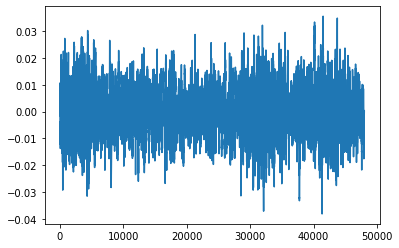

In [ ]:
# Define start offset amount (useful to avoid fade-ins many recordings contain)
# audio is sampled at 16khz 
startOffset = 16000

# Length of audio clips in seconds
lengthInSeconds = 3

# Define the stop time as the start time + the length converted to
stopTime = (lengthInSeconds * 16000) + startOffset

# Trim the, starting at the start offset, ending at the stop time.
processed = test_audio[startOffset:stopTime]

# plot a waveform of the trimmed audio tensor.
plt.figure()
plt.plot(processed.numpy())

**Define function for Pre-processing audio into tensors**

In [ ]:
def decode_audio(audio_binary):

  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  
  # Crop audio into the size defined earlier.
  audio = audio[startOffset:stopTime] 
  
  # As all the data is single channel (mono), drop the `channels` axis from the array.
  # Removes deminsion size from the tensor as its mono. 
  return tf.squeeze(audio, axis=-1)

**Define function for defining labels based on the parent folder (night/day)**

In [ ]:
def get_label(file_path):
  # get the label of the file from its parent folder

  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

Defines function that Combines the waveform and the label together by calling the previous 

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path) # Call function to get the label
  audio_binary = tf.io.read_file(file_path) # Read audio
  waveform = decode_audio(audio_binary) # Call function to decode audio
  return waveform, label # Return waveform tensor and label

Build the training set using the function built previously

In [ ]:
# The number of elements to prefetch should be equal to or greater than the number of batches consumed by a single training step. 
# this value tuned autmaticcaly using "tf.data.AUTOTUNE", which will prompt the tf.data runtime to tune the value dynamically at runtime.
AUTOTUNE = tf.data.AUTOTUNE 

# tranfsers the training set inot turns the training set into  
files_ds = tf.data.Dataset.from_tensor_slices(train_files[1:stopTime]) 

# runs the functions to combine waveform and label data defined previously
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

# Convert dataset to spectogram

Convert wav tensors to spectogram

In [ ]:
def get_spectrogram(waveform):
  # converts the waveform tensors into float 32 tensors.
  waveform = tf.cast(waveform, dtype=tf.float32)
  
  # Turn waveform into  a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) # frame length of 255, Step length of 128
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so spectrogram can be used as image input for convolution layers
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Function to plot spectogram

In [ ]:
def plot_spectrogram(spectrogram, ax):

  # Defines the size of the spectogram if it is greater than 2
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  
  # Convert frequencies into log scale and set time is on the x-axis.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)   # epsilon helps avoid taking a log of zero.
  height = log_spec.shape[0] # Reset the height to match new log height
  width = log_spec.shape[1] # Reset the width to match new log width
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int) 
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec) 

Get the corrosponding label for the spectogram

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio) # Runs the spectorgram conversion code
  label_id = tf.argmax(label == commands) # Gets the labels
  return spectrogram, label_id

Runs previous functions to fully convert data set to spectograms

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id, # Converts wav to spectogram and attaches labels
  num_parallel_calls=AUTOTUNE)

# Debugging audio, waveforms and spectogram

used for debugging, not required to be run for the algorithm to work

Play audio and print information.

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Night
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Draw 9 random waveforms from data set 

For use in Debugging

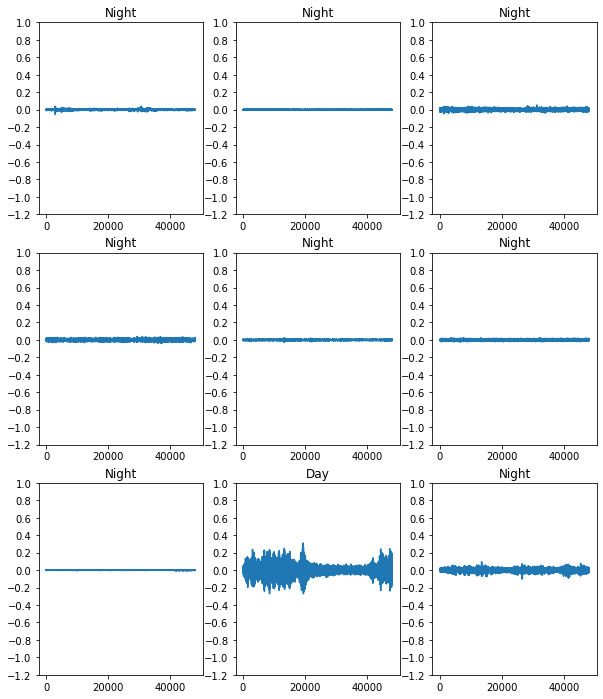

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Show waveform along side its spectogram.

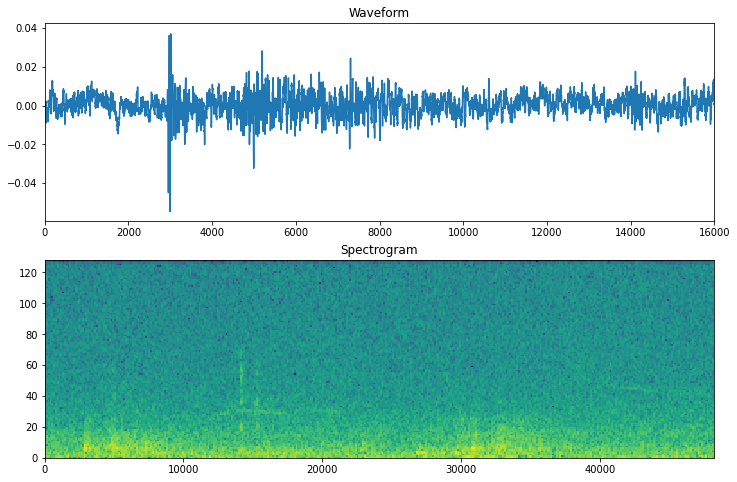

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Draw 9 spectograms to help debug

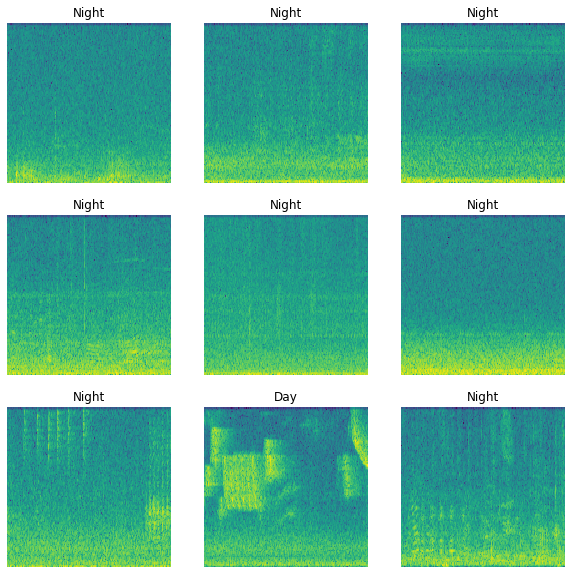

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Build Model

Build the testing and validation sets in the same way as the training data set

In [ ]:
# Replaces the input files with the corresponding spectograms
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
# Replace the waves in each set with its respective spectogram
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Define the batch size of training and validation sets

In [ ]:
# Define the batch sizes
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add Dataset.cache and Dataset.prefetch operations to 

reduce read latency while training the model

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

The model is a convolutional neural network (CNN), usable because the audio were converted to spectograms.

In [ ]:
# prints the size of the input
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Define the layers for the model.
model = models.Sequential([
                           
    #Input layer
    layers.Input(shape=input_shape), 


    # Normalisation.
    norm_layer,

    # Hidden Layers 
    layers.Conv2D(64, 4, activation='relu'), # Convolution layer
    layers.MaxPooling2D(), # Downsamples input along height and width
    layers.Dropout(0.25), # Drop out layer Helps prevent over fitting 
    layers.Flatten(), # 
    layers.Dense(64, activation='relu'),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(num_labels),
])

model.summary()

Input shape: (374, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 374, 129, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 371, 126, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 185, 63, 64)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 185, 63, 64)       0         
                                                                 
 flatten (Flatten)           (None, 745920)            0         
                                                                 
 dense (Dense)               

**Compile model**

In [ ]:
# compile the model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Run model

Using training set, validation set and number of epochs

In [ ]:
EPOCHS = 100 # Define number of epochs in training

# Run the model for the defined number of epochs, while recording the loss of each epoch.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/100
104/104 [==============================] - 2325s 23s/step - loss: 0.6913 - accuracy: 0.5208 - val_loss: 0.6893 - val_accuracy: 0.5316
Epoch 2/100
104/104 [==============================] - 6s 55ms/step - loss: 0.6705 - accuracy: 0.5748 - val_loss: 0.6683 - val_accuracy: 0.5777
Epoch 3/100
104/104 [==============================] - 6s 55ms/step - loss: 0.5892 - accuracy: 0.6567 - val_loss: 0.6561 - val_accuracy: 0.6262
Epoch 4/100
104/104 [==============================] - 6s 55ms/step - loss: 0.4694 - accuracy: 0.7613 - val_loss: 0.7635 - val_accuracy: 0.6383
Epoch 5/100
104/104 [==============================] - 6s 55ms/step - loss: 0.3835 - accuracy: 0.8062 - val_loss: 0.8579 - val_accuracy: 0.6481
Epoch 6/100
104/104 [==============================] - 6s 55ms/step - loss: 0.3113 - accuracy: 0.8650 - val_loss: 0.7846 - val_accuracy: 0.7112
Epoch 7/100
104/104 [==============================] - 6s 55ms/step - loss: 0.2352 - accuracy: 0.8920 - val_loss: 0.9167 - val_accurac

# Evaluate Performance

display how the loss value for both the training set and the validation set changed over the training period

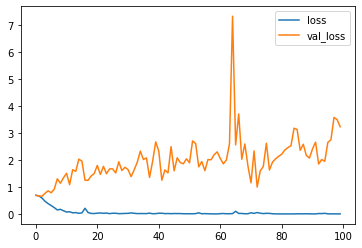

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Run the alogirhtm on the test data set to determine its accuracy on new data.

In [ ]:
# Rerun the model using the testing data
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
# Calculate test accuracy.
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


**Confusion matrix**

Shows how the algorithm alocates files, 
is also useful in the debugging of overfitting

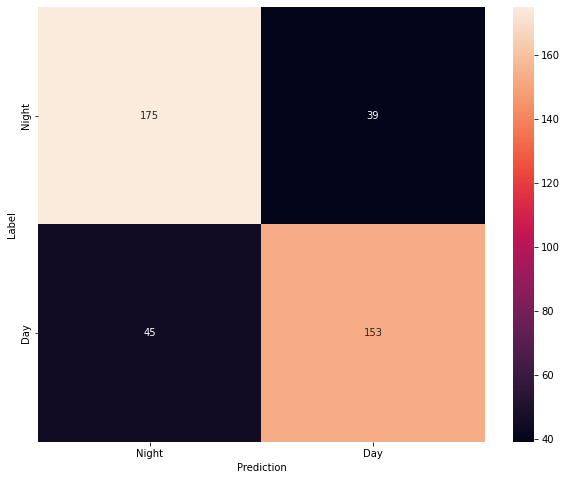

In [ ]:
# Plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Resest Model

used in development to reset history and the model without have to reset preprocessing

In [ ]:
history = None
model = None